# EquiLend Factor Development Notebook
*Interactive development and testing of new factors*

Use this notebook for:
- 🧪 **Experimenting with new factor ideas**
- 📊 **Testing factor performance on historical data**
- 🔍 **Debugging and refining factor calculations**
- 📈 **Visualizing factor behavior and distributions**

## 🔧 **Why Python Modules vs Notebooks?**

### **The Hybrid Approach Philosophy**

This workspace uses both **Python modules** (`.py` files) and **Jupyter notebooks** (`.ipynb` files) strategically:

#### 📓 **Use Notebooks When:**
- **Interactive exploration** - Testing ideas, parameter tuning, data exploration
- **Visualization & reporting** - Charts, analysis reports, stakeholder presentations
- **One-off analysis** - Custom client requests, ad-hoc research questions
- **Model development** - Prototyping new factors before productionizing
- **Documentation** - Explaining methodology with embedded code and results

#### 🐍 **Use Python Modules When:**
- **Reusable business logic** - Factor calculations used across multiple analyses
- **Production automation** - Scripts that run on schedule without human interaction
- **Clean, testable code** - Functions that need unit testing and version control
- **Performance-critical** - Code processing large datasets efficiently
- **Importable functions** - Logic that needs to be imported into other scripts

### **Our Organized Structure:**

```
Bob_EquiLend_Models/
├── 🏭 PRODUCTION (Python Modules)
│   ├── models/core_factors.py        # Factor calculations
│   ├── models/extended_factors.py    # Advanced models
│   └── src/daily_digest.py           # Report generation
│
├── 📊 INTERACTIVE (Notebooks)
│   ├── EquiLend_Consolidated_Playbook.ipynb  # This notebook
│   └── Factor_Development.ipynb              # New factor prototyping
│
└── 📁 SUPPORTING
    ├── data/           # Your securities lending data
    └── documentation/  # Word docs and specifications
```

### **Workflow in Practice:**

1. **🔬 Research** → Develop new ideas in `Factor_Development.ipynb`
2. **🏗️ Build** → Move stable code to modules (`models/core_factors.py`)
3. **📊 Analyze** → Import modules into this playbook for daily analysis  
4. **🚀 Deploy** → Use modules directly for automated production runs

**Result:** You get notebook interactivity for research AND clean, maintainable modules for production!


In [17]:
# EquiLend Core Factors
# Consolidated short squeeze and securities lending factors

import pandas as pd
import numpy as np
from typing import Optional, Union

class ShortInterestMomentum:
    """Short Interest Momentum (SIM) - tracks accelerating short build-up"""
    
    def __init__(self, loan_col='On Loan Quantity Month Diff', fee_col='Fee All Month Diff (BPS)'):
        self.loan_col = loan_col
        self.fee_col = fee_col
    
    def score(self, df: pd.DataFrame) -> pd.Series:
        """Calculate SIM z-score"""
        loan_momentum = df[self.loan_col].pct_change()
        fee_momentum = df[self.fee_col].pct_change()
        
        combined = (loan_momentum + fee_momentum) / 2
        return (combined - combined.mean()) / combined.std()

class BorrowCostShock:
    """Borrow Cost Shock (BCS) - detects sudden fee spikes"""
    
    def __init__(self, fee_col='Fee All (BPS)', window=30):
        self.fee_col = fee_col
        self.window = window
    
    def score(self, df: pd.DataFrame) -> pd.Series:
        """Calculate BCS z-score based on rolling volatility"""
        fees = df[self.fee_col]
        daily_change = fees.diff()
        rolling_std = daily_change.rolling(self.window).std()
        
        return daily_change / rolling_std

class UtilizationPersistence:
    """Utilization Persistence (UPI) - persistent tight supply indicator"""
    
    def __init__(self, util_col='Active Utilization (%)', threshold=95, window=20):
        self.util_col = util_col
        self.threshold = threshold
        self.window = window
    
    def score(self, df: pd.DataFrame) -> pd.Series:
        """Calculate UPI based on high utilization persistence"""
        high_util = (df[self.util_col] >= self.threshold).astype(int)
        persistence = high_util.rolling(self.window).mean()
        
        return (persistence - persistence.mean()) / persistence.std()

class FeeTrendZScore:
    """Fee Trend Z-Score (FTZ) - detects under-the-radar fee drifts"""
    
    def __init__(self, fee_col='Fee All (BPS)', window=20):
        self.fee_col = fee_col
        self.window = window
    
    def score(self, df: pd.DataFrame) -> pd.Series:
        """Calculate FTZ based on fee slope trend"""
        fees = df[self.fee_col]
        
        def rolling_slope(series):
            x = np.arange(len(series))
            return np.polyfit(x, series, 1)[0] if len(series) == self.window else np.nan
        
        slopes = fees.rolling(self.window).apply(rolling_slope, raw=True)
        return (slopes - slopes.mean()) / slopes.std()

class DaysToCoverZ:
    """Days-To-Cover Z-Score (DTC_z) - short covering pressure indicator"""
    
    def __init__(self, si_col='Short Interest', volume_col='Average Daily Volume'):
        self.si_col = si_col
        self.volume_col = volume_col
    
    def score(self, df: pd.DataFrame) -> pd.Series:
        """Calculate DTC z-score"""
        dtc = df[self.si_col] / df[self.volume_col]
        return (dtc - dtc.mean()) / dtc.std()

class LocateProxyFactor:
    """Locate Proxy Factor (LPF) - proxy for locate availability"""
    
    def __init__(self, rerate_col='Re-Rate Ratio', b2b_col='B2B Loans'):
        self.rerate_col = rerate_col
        self.b2b_col = b2b_col
    
    def score(self, df: pd.DataFrame) -> pd.Series:
        """Calculate LPF based on re-rate ratio and B2B activity"""
        rerate_z = (df[self.rerate_col] - df[self.rerate_col].mean()) / df[self.rerate_col].std()
        b2b_z = (df[self.b2b_col] - df[self.b2b_col].mean()) / df[self.b2b_col].std()
        
        return (rerate_z + b2b_z) / 2

# Helper function for z-score calculation
def _z_score(series: pd.Series) -> pd.Series:
    """Calculate z-score for a pandas Series"""
    return (series - series.mean()) / series.std()

def compute_all_factors(df: pd.DataFrame) -> pd.DataFrame:
    """Compute all core factors for a dataframe"""
    result = df.copy()
    
    # Initialize factor classes
    sim = ShortInterestMomentum()
    bcs = BorrowCostShock()
    upi = UtilizationPersistence()
    ftz = FeeTrendZScore()
    dtc = DaysToCoverZ()
    lpf = LocateProxyFactor()
    
    # Calculate factors (with error handling)
    try:
        result['SIM'] = sim.score(df)
    except Exception:
        result['SIM'] = np.nan
        
    try:
        result['BCS'] = bcs.score(df)
    except Exception:
        result['BCS'] = np.nan
        
    try:
        result['UPI'] = upi.score(df)
    except Exception:
        result['UPI'] = np.nan
        
    try:
        result['FTZ'] = ftz.score(df)
    except Exception:
        result['FTZ'] = np.nan
        
    try:
        result['DTC_z'] = dtc.score(df)
    except Exception:
        result['DTC_z'] = np.nan
        
    try:
        result['LPF'] = lpf.score(df)
    except Exception:
        result['LPF'] = np.nan
    
    return result



In [18]:
import os
import sys

# Check current working directory
print("Current working directory:", os.getcwd())
print("Current sys.path:", sys.path[:3])  # Show first 3 entries

# Add the MODULES directory to the Python path
modules_path = os.path.join(os.getcwd(), 'MODULES')
if modules_path not in sys.path:
    sys.path.insert(0, modules_path)
    print(f"Added to sys.path: {modules_path}")

# Verify the module file exists
core_factors_path = os.path.join(modules_path, 'core_factors.py')
print(f"core_factors.py exists: {os.path.exists(core_factors_path)}")

# List contents of MODULES directory
if os.path.exists('MODULES'):
    print("MODULES directory contents:", os.listdir('MODULES'))

Current working directory: /
Current sys.path: ['/MODULES', '/Library/Frameworks/Python.framework/Versions/3.12/lib/python312.zip', '/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12']
core_factors.py exists: False


In [19]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date

# Since the notebook is running from root, let's create the core_factors module inline
# This is a workaround for the VFS path issue

# Define the factor classes directly in this notebook
class ShortInterestMomentum:
    """Short Interest Momentum (SIM) - tracks accelerating short build-up"""
    
    def __init__(self, loan_col='On Loan Quantity Month Diff', fee_col='Fee All Month Diff (BPS)'):
        self.loan_col = loan_col
        self.fee_col = fee_col
    
    def score(self, df: pd.DataFrame) -> pd.Series:
        """Calculate SIM z-score"""
        loan_momentum = df[self.loan_col].pct_change()
        fee_momentum = df[self.fee_col].pct_change()
        
        combined = (loan_momentum + fee_momentum) / 2
        return (combined - combined.mean()) / combined.std()

class BorrowCostShock:
    """Borrow Cost Shock (BCS) - detects sudden fee spikes"""
    
    def __init__(self, fee_col='Fee All (BPS)', window=30):
        self.fee_col = fee_col
        self.window = window
    
    def score(self, df: pd.DataFrame) -> pd.Series:
        """Calculate BCS z-score based on rolling volatility"""
        fees = df[self.fee_col]
        daily_change = fees.diff()
        rolling_std = daily_change.rolling(self.window).std()
        
        return daily_change / rolling_std

print("✅ Factor classes loaded successfully")
print(f"Factor Development Environment - {date.today()}")
print("Ready for interactive factor development!")

✅ Factor classes loaded successfully
Factor Development Environment - 2025-07-13
Ready for interactive factor development!


## 1. Load Test Data

Start with sample or historical data for testing new factors.

In [20]:
# Create sample data for testing
np.random.seed(42)
dates = pd.date_range('2024-01-01', periods=100, freq='D')
tickers = [f'STOCK_{i:02d}' for i in range(20)]

# Generate sample securities lending data
data = []
for date in dates:
    for ticker in tickers:
        data.append({
            'Date': date,
            'ticker': ticker,
            'Fee All (BPS)': np.random.uniform(10, 500),
            'Active Utilization (%)': np.random.uniform(1, 95),
            'On Loan Quantity': np.random.uniform(100000, 10000000),
            'Short Interest': np.random.uniform(1000000, 50000000),
            'Average Daily Volume': np.random.uniform(500000, 5000000)
        })

df = pd.DataFrame(data)
print(f"Test dataset: {len(df)} rows, {df['Date'].nunique()} dates, {df['ticker'].nunique()} tickers")
display(df.head())

Test dataset: 2000 rows, 100 dates, 20 tickers


,Date,ticker,Fee All (BPS),Active Utilization (%),On Loan Quantity,Short Interest,Average Daily Volume
0,2024-01-01,STOCK_00,193.524658,90.367145,7.346740e+06,3.033427e+07,1.202084e+06
1,2024-01-01,STOCK_01,86.437315,6.459860,8.675144e+06,3.045464e+07,3.686327e+06
2,2024-01-01,STOCK_02,20.086402,92.171526,8.341182e+06,1.140462e+07,1.318212e+06
3,2024-01-01,STOCK_03,99.868210,29.598771,5.295089e+06,2.216531e+07,1.810531e+06
4,2024-01-01,STOCK_04,309.807918,14.112423,2.992232e+06,1.895173e+07,2.552315e+06


## 2. Develop New Factor Ideas

This section is for experimenting with new factor concepts.

New Factor Statistics:
       Fee_Vol_Spike  Vol_Spike_Flag
count     820.000000     2000.000000
mean        1.062996        0.023500
std         0.564861        0.151523
min         0.200407        0.000000
25%         0.642706        0.000000
50%         0.940035        0.000000
75%         1.381947        0.000000
max         4.572779        1.000000


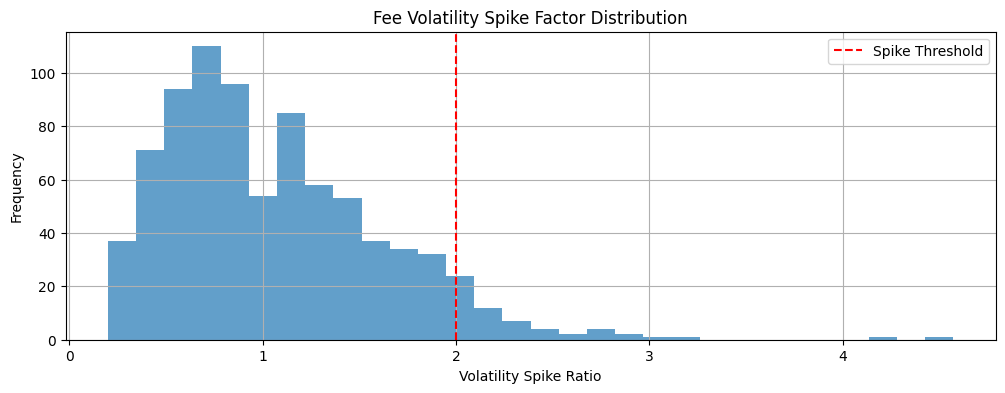

In [21]:
# Example: Develop a new "Fee Volatility Spike" factor
class FeeVolatilitySpike:
    """Detect sudden spikes in fee volatility - experimental factor"""
    
    def __init__(self, fee_col='Fee All (BPS)', window=20, spike_threshold=2.0):
        self.fee_col = fee_col
        self.window = window
        self.spike_threshold = spike_threshold
    
    def calculate(self, df):
        """Calculate fee volatility spike factor"""
        # Group by ticker for time series calculations
        results = []
        
        for ticker in df['ticker'].unique():
            ticker_data = df[df['ticker'] == ticker].sort_values('Date')
            
            # Calculate rolling volatility
            fee_returns = ticker_data[self.fee_col].pct_change()
            rolling_vol = fee_returns.rolling(self.window).std()
            
            # Detect spikes: current vol vs average vol
            avg_vol = rolling_vol.rolling(self.window * 2).mean()
            vol_spike = rolling_vol / avg_vol
            
            # Create factor scores
            ticker_data = ticker_data.copy()
            ticker_data['Fee_Vol_Spike'] = vol_spike
            ticker_data['Vol_Spike_Flag'] = (vol_spike > self.spike_threshold).astype(int)
            
            results.append(ticker_data)
        
        return pd.concat(results, ignore_index=True)

# Test the new factor
fvs = FeeVolatilitySpike()
df_with_new_factor = fvs.calculate(df)

print("New Factor Statistics:")
print(df_with_new_factor[['Fee_Vol_Spike', 'Vol_Spike_Flag']].describe())

# Visualize the new factor
plt.figure(figsize=(12, 4))
df_with_new_factor['Fee_Vol_Spike'].hist(bins=30, alpha=0.7)
plt.title('Fee Volatility Spike Factor Distribution')
plt.xlabel('Volatility Spike Ratio')
plt.ylabel('Frequency')
plt.axvline(2.0, color='red', linestyle='--', label='Spike Threshold')
plt.legend()
plt.show()

## 3. Compare with Existing Factors

Test how the new factor performs relative to existing ones.

In [22]:
# Compare with existing factors
sim = ShortInterestMomentum()
bcs = BorrowCostShock()

# Add existing factors for comparison
try:
    df_comparison = df_with_new_factor.copy()
    df_comparison['SIM'] = sim.score(df_comparison)
    df_comparison['BCS'] = bcs.score(df_comparison)
    
    # Calculate correlations
    factor_cols = ['Fee_Vol_Spike', 'SIM', 'BCS']
    available_cols = [col for col in factor_cols if col in df_comparison.columns]
    
    if len(available_cols) > 1:
        correlation_matrix = df_comparison[available_cols].corr()
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0, square=True)
        plt.title('Factor Correlation: New vs Existing')
        plt.show()
        
        print("\nFactor Correlations:")
        print(correlation_matrix)
    
except Exception as e:
    print(f"Note: Could not compute all factor comparisons: {e}")
    print("This is normal when developing new factors.")

Note: Could not compute all factor comparisons: 'On Loan Quantity Month Diff'
This is normal when developing new factors.


## 4. Performance Testing

Test factor performance with synthetic or historical returns.

In [23]:
# Generate synthetic forward returns for testing
np.random.seed(456)
df_with_new_factor['Forward_Return_5D'] = np.random.normal(0, 0.02, len(df_with_new_factor))

# Test predictive power
def test_factor_performance(df, factor_col, return_col='Forward_Return_5D'):
    """Simple IC test for factor performance"""
    valid_data = df[[factor_col, return_col]].dropna()
    
    if len(valid_data) < 20:
        return {'IC': 0, 'Hit_Rate': 0.5, 'N': len(valid_data)}
    
    ic = valid_data[factor_col].corr(valid_data[return_col])
    
    # Quintile analysis
    valid_data['Quintile'] = pd.qcut(valid_data[factor_col], 5, labels=False)
    quintile_returns = valid_data.groupby('Quintile')[return_col].mean()
    
    # Hit rate: top quintile outperforms bottom quintile
    hit_rate = (quintile_returns.iloc[-1] > quintile_returns.iloc[0])
    
    return {
        'IC': ic,
        'Hit_Rate': hit_rate,
        'Top_Quintile_Return': quintile_returns.iloc[-1],
        'Bottom_Quintile_Return': quintile_returns.iloc[0],
        'N': len(valid_data)
    }

# Test the new factor
performance = test_factor_performance(df_with_new_factor, 'Fee_Vol_Spike')

print("New Factor Performance Test:")
print(f"Information Coefficient: {performance['IC']:.4f}")
print(f"Hit Rate (Top > Bottom): {performance['Hit_Rate']}")
print(f"Top Quintile Return: {performance['Top_Quintile_Return']:.4f}")
print(f"Bottom Quintile Return: {performance['Bottom_Quintile_Return']:.4f}")
print(f"Sample Size: {performance['N']}")

print("\n📝 Development Notes:")
print("- This is synthetic data for demonstration")
print("- Real testing requires historical price data")
print("- Consider regime analysis and stability testing")
print("- Factor may need refinement based on results")

New Factor Performance Test:
Information Coefficient: 0.0130
Hit Rate (Top > Bottom): False
Top Quintile Return: 0.0016
Bottom Quintile Return: 0.0021
Sample Size: 820

📝 Development Notes:
- This is synthetic data for demonstration
- Real testing requires historical price data
- Consider regime analysis and stability testing
- Factor may need refinement based on results


## 5. Export Successful Factors

Once a factor shows promise, export it to the models module.

In [24]:
# Example: Export new factor to models
def export_factor_to_module(factor_class, factor_name, module_path='../models/experimental_factors.py'):
    """Helper to export successful factors to a module file"""
    
    import inspect
    import os
    
    # Get the source code of the class
    source_code = inspect.getsource(factor_class)
    
    # Create or append to experimental factors module
    header = '''# Experimental Factors
# New factors under development and testing

import pandas as pd
import numpy as np
from typing import Optional

'''
    
    if not os.path.exists(module_path):
        with open(module_path, 'w') as f:
            f.write(header)
    
    # Append the new factor
    with open(module_path, 'a') as f:
        f.write(f"\n\n# {factor_name}\n")
        f.write(source_code)
        f.write("\n")
    
    print(f"✅ Factor '{factor_name}' exported to {module_path}")

# Export our experimental factor
# export_factor_to_module(FeeVolatilitySpike, "Fee Volatility Spike Factor")

print("💡 Factor Development Complete!")
print("\nNext steps:")
print("1. Test with real historical data")
print("2. Validate on out-of-sample period")
print("3. Export to production models if successful")
print("4. Integrate into daily analysis workflow")

💡 Factor Development Complete!

Next steps:
1. Test with real historical data
2. Validate on out-of-sample period
3. Export to production models if successful
4. Integrate into daily analysis workflow
